<a href="https://colab.research.google.com/github/davidnussio/covid-19-ticino/blob/master/Covid_Ticino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title
!pip install -q lmfit

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 235kB 8.7MB/s 


In [0]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
import numpy 
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from lmfit import Model, Parameters

In [0]:
# https://www.wikiwand.com/en/Generalised_logistic_function

# Sigmoid model
def sigmoid(x, a, b, c):
  return a / (1 + numpy.exp(-b*(x-c)))

# Exponational model
def exponational(x, a, b):
  return a * numpy.exp(b * x)

# Fst derivate
def sigmoid_dx(x, a, b, c):
  return (a * b * numpy.exp(-b*(x-c))) / ((numpy.exp(-b*(x-c)) + 1) ** 2)

In [5]:
#@title Configuration

num_sample = 50 #@param {type:"slider", min:20, max:50, step:1}

moving_avarage_win = 5 #@param {type:"integer"}

csv_url_file = "https://raw.githubusercontent.com/davidnussio/covid-19-ticino/master/data/covid-19-ticino.csv" #@param ["https://raw.githubusercontent.com/davidnussio/covid-19-ticino/master/data/covid-19-ticino.csv", "https://raw.githubusercontent.com/openZH/covid_19/master/fallzahlen_kanton_total_csv/COVID19_Fallzahlen_Kanton_VD_total.csv"]

print('num_sample: ',num_sample)
print('moving_avarage_win: ', moving_avarage_win)

num_sample:  50
moving_avarage_win:  5


In [6]:
# Load data from github repo (github.com/davidnussio/covid-19-ticino)
csv_data = pd.read_csv(csv_url_file)
data = csv_data.fillna(method='ffill').fillna(0)

# Daily infected patients
new_infected = csv_data['ncumul_conf'].fillna(method='ffill').diff()
new_infected[0] = 1

# Number of data days
number_of_days = len(data['ncumul_conf'])

# Cumulative infected
yData = data['ncumul_conf']

# Fit number of sample to number of days
num_sample = min(num_sample, number_of_days)

# Days vector
xData = numpy.linspace(0, number_of_days, number_of_days)
xDataSample = numpy.linspace(0, num_sample, num_sample)

# Moving avarage
r = new_infected.rolling(moving_avarage_win, center=True, win_type='gaussian')
new_infected_rolling = r.mean(std=3)

#
yData_rolling = new_infected_rolling.cumsum().fillna(0)

#yData = yData_rolling

print('Numer of sample', num_sample)
print('Number of days: ', number_of_days)
print('Date range: [', data['date'][0], '- ', data['date'][number_of_days - 1], ']')
# yData
data.tail()

Numer of sample 39
Number of days:  39
Date range: [ 2020-02-25 -  2020-04-03 ]


,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,ncumul_hosp,ncumul_ICU,ncumul_vent,ncumul_released,ncumul_deceased,source,TotalPosTests1
34,2020-03-30,08:00,TI,0.0,1962.0,415.0,75.0,61.0,0.0,105.0,https://www4.ti.ch/area-media/comunicati/detta...,68.0
35,2020-03-31,08:00,TI,0.0,2091.0,401.0,74.0,67.0,202.0,120.0,https://www4.ti.ch/area-media/comunicati/detta...,68.0
36,2020-04-01,08:00,TI,0.0,2195.0,396.0,76.0,72.0,229.0,132.0,https://www4.ti.ch/area-media/comunicati/detta...,68.0
37,2020-04-02,08:00,TI,0.0,2271.0,374.0,75.0,73.0,263.0,141.0,https://www4.ti.ch/area-media/comunicati/detta...,68.0
38,2020-04-03,08:00,TI,0.0,2377.0,370.0,75.0,67.0,287.0,155.0,https://www4.ti.ch/area-media/comunicati/detta...,68.0


In [7]:
# Model
smodel = Model(sigmoid)
fit_params = Parameters()
fit_params.add('a', value=500, min=200, max=10000)
fit_params.add('b', value=0.05, min=0, max=5)
fit_params.add('c', value=30, min=1, max=200)
#fit_params.add('d', value=1, min=0.95, max=1.15)

result = smodel.fit(yData[:num_sample], fit_params, x=xDataSample, fit_kws={'reduce_fcn':'negentropy'})

result

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

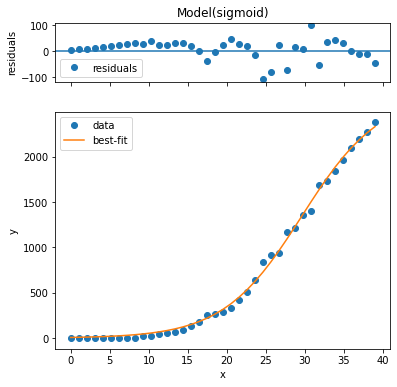

In [8]:
result.plot()

In [9]:
# Model
emodel = Model(exponational)
exp_fit_params = Parameters()
exp_fit_params.add('a', value=1, min=0.01, max=200)
exp_fit_params.add('b', value=1, min=0.01, max=5)

exp_result = emodel.fit(yData, exp_fit_params, x=xDataSample) #, fit_kws={'reduce_fcn':'negentropy'})

exp_result

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

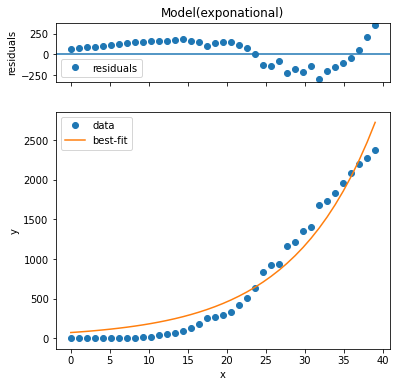

In [10]:
exp_result.plot()

In [11]:
#@title
print('Number of day', number_of_days)

# Infected guess
infected_lower = int(round(result.params['a'].value - result.params['a'].stderr))
infected_upper = int(round(result.params['a'].value + result.params['a'].stderr))
print('Infected: ', infected_lower, ' - ', infected_upper)

# Peak day
peak_day_lower = int(round(result.params['c'].value - result.params['c'].stderr))
peak_day_upper = int(round(result.params['c'].value + result.params['c'].stderr))
print('Peak day: ', peak_day_lower, ' - ', peak_day_upper)

# Date
print('Peak date: ', data['date'][peak_day_lower], ' - ', data['date'][peak_day_upper])

Number of day 39
Infected:  2626  -  2755
Peak day:  29  -  30
Peak date:  2020-03-25  -  2020-03-26


- Number of day 31
- Infected:  1779  -  2064
- Peak day:  26  -  27
- Peak date:  2020-03-22  -  2020-03-23

---

- Number of day 32
- Infected:  2040  -  2345
- Peak day:  27  -  28
- Peak date:  2020-03-23  -  2020-03-24

---

- Number of day 34
- Infected:  2209  -  2421
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

---

- Number of day 35
- Infected:  2304  -  2492
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

---

- Number of day 36
- Infected:  2411  -  2587
- Peak day:  28  -  29
- Peak date:  2020-03-24  -  2020-03-25

---

- Number of day 38
- Infected:  2560  -  2701
- Peak day:  29  -  30
- Peak date:  2020-03-25  -  2020-03-26

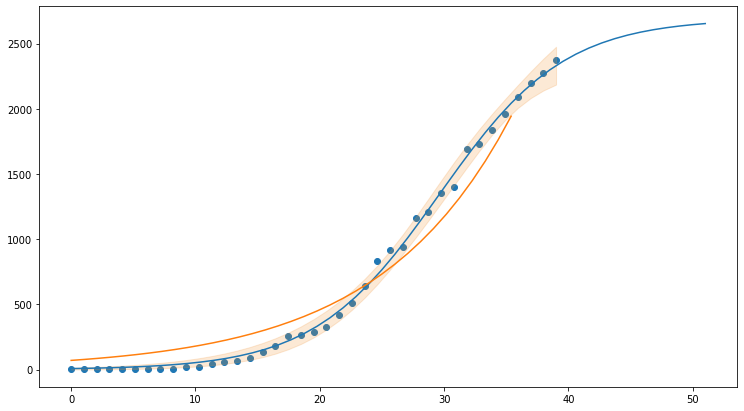

In [12]:
# Predicted n days
predicted_days = 50
x = numpy.linspace(0, predicted_days + 1, predicted_days)

ySigmoid_dx = [sigmoid_dx(i, 
                          result.params['a'].value,
                          result.params['b'].value,
                          result.params['c'].value,
                          ) for i in x]

ySigmoid = smodel.eval(result.params, x=x)
yExponential = emodel.eval(exp_result.params, x=x)

ySigmoid2 = [sigmoid(i, 
                    result.params['a'].value - result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value + result.params['c'].stderr,
                    ) for i in x]

ySigmoid3 = [sigmoid(i, 
                    result.params['a'].value + result.params['a'].stderr,
                    result.params['b'].value,
                    result.params['c'].value - result.params['c'].stderr,
                    ) for i in x]

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 7, forward=True)

ax.scatter(xData, data['ncumul_conf'])

# 
dely = result.eval_uncertainty(sigma=5)
exp_dely = exp_result.eval_uncertainty(sigma=5)

ax.plot(x, smodel.eval(params=result.params, x=x), label='sigmoid', zorder=100)

ax.plot(x[:35], emodel.eval(params=exp_result.params, x=x[:35]), label='exp', zorder=100)

plt.fill_between(xDataSample, result.best_fit-dely, result.best_fit+dely, color="#f19131", alpha=0.2)
#plt.fill_between(xDataSample, 
                #  exp_result.best_fit-exp_dely, exp_result.best_fit+exp_dely, 
                #  color="#44cc44", alpha=0.1)

plt.savefig('drive/My Drive/Colab Notebooks/Covid-Ticino/data-vs-model.png', dpi=100)

# Probability density function

**rolling average** (or moving average)

[jhsph study → 5.1 days](https://www.jhsph.edu/news/news-releases/2020/new-study-on-COVID-19-estimates-5-days-for-incubation-period.html)


<BarContainer object of 39 artists>

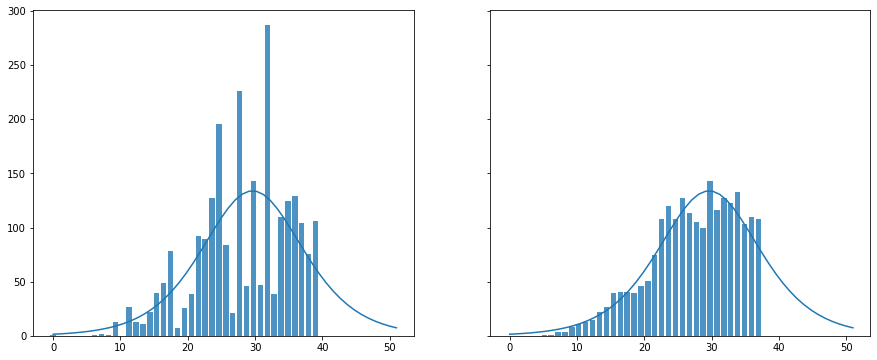

In [13]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')

fig.set_size_inches(15, 6, forward=True)

xInf = numpy.linspace(0, len(new_infected), len(new_infected))

ax[0].plot(x, ySigmoid_dx)
ax[0].bar(xInf, new_infected, alpha=0.8)

ax[1].plot(x, ySigmoid_dx)
ax[1].bar(xInf, new_infected_rolling, alpha=0.8)


Tomorrow prediction: 40
 ↓  2537
 →  2465
 ↑  2393


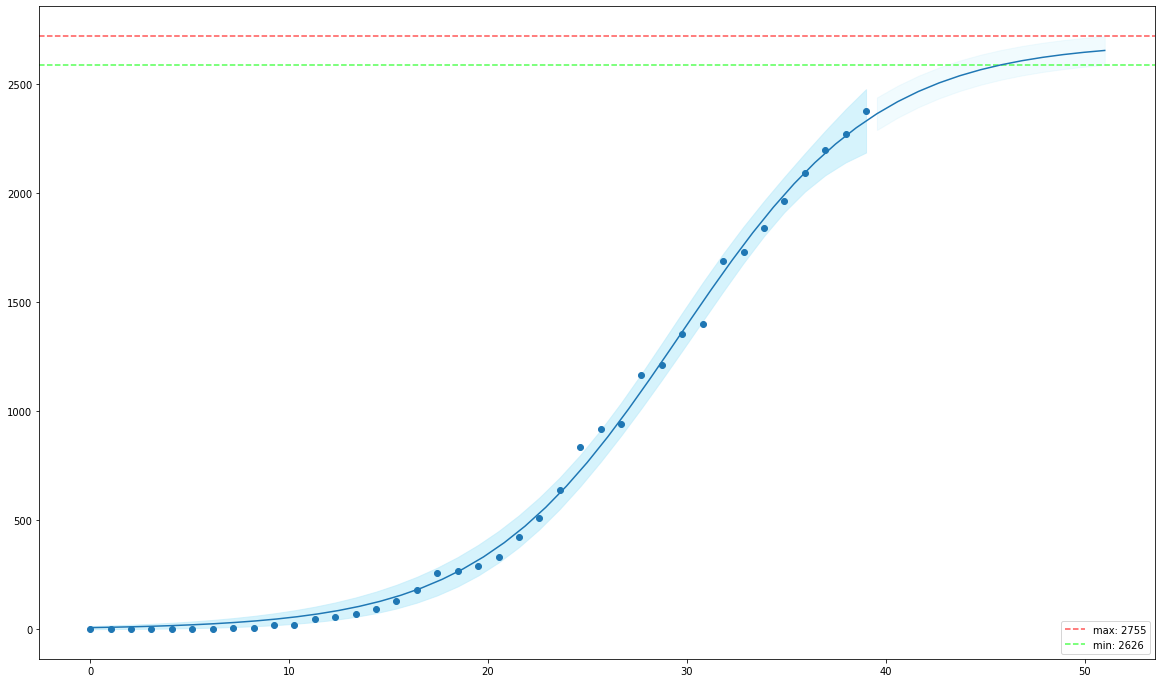

In [14]:
fig, ax = plt.subplots()

fig.set_size_inches(20, 12, forward=True)

#ax.axhline(result.params['a'].value + result.params['a'].stderr, linestyle='dashed', color='#ff5555')
#ax.axhline(result.params['a'].value - result.params['a'].stderr, linestyle='dashed', color='#55ff55')

ax.axhline(ySigmoid3[-1], linestyle='dashed', color='#ff5555')
ax.axhline(ySigmoid2[-1], linestyle='dashed', color='#55ff55')

ax.legend(("max: " + str(infected_upper), "min: " + str(infected_lower)))

next_data = len(result.best_fit) - 1

ax.fill_between(x[next_data:], ySigmoid2[next_data:], ySigmoid3[next_data:], color="#bbebfb", alpha=0.2)

ax.plot(x, ySigmoid)

plt.fill_between(xDataSample, result.best_fit-dely, result.best_fit+dely, color="#bbebfb", alpha=0.6)

ax.scatter(xDataSample, data['ncumul_conf'])

print('Tomorrow prediction:', number_of_days + 1)
print(' ↓ ', int(round(ySigmoid3[number_of_days + 1])))
print(' → ', int(round(ySigmoid[number_of_days + 1])))
print(' ↑ ', int(round(ySigmoid2[number_of_days + 1])))



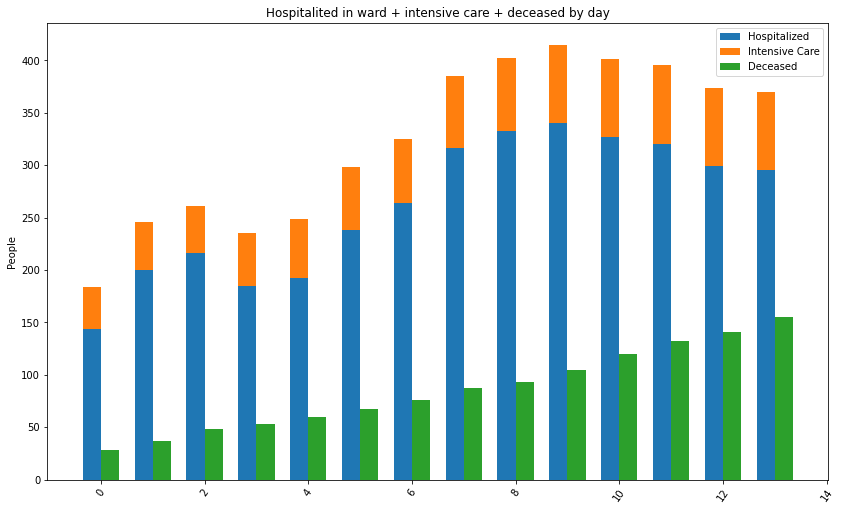

In [24]:
skip_data = 25
dates = data['date'][skip_data:]
ncumul_hosp = data['ncumul_hosp'][skip_data:].fillna(0)
ncumul_ICU = data['ncumul_ICU'][skip_data:].fillna(0)
ncumul_deceased = data['ncumul_deceased'][skip_data:].fillna(0)

ncumul_ward = ncumul_hosp - ncumul_ICU

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(14, 8.4, forward=True)

#ax.bar(dates, ncumul_ward, width, label='Hospitalized')
#ax.plot(dates, ncumul_ward)

#ax.bar(dates, ncumul_ICU, width, bottom=ncumul_ward, label='Intensive Care')

# ax.bar(dates, ncumul_deceased, width, 
#        bottom=ncumul_hosp, label='Deceased')

x = numpy.arange(len(dates))
ax.bar(x - width/2, ncumul_ward, width, label='Hospitalized')
ax.bar(x - width/2, ncumul_ICU, width, bottom=ncumul_ward, label='Intensive Care')
ax.bar(x + width/2, ncumul_deceased, width, label='Deceased')

for tick in ax.get_xticklabels():
  tick.set_rotation(55)

fig.align_labels()
ax.set_ylabel('People')
ax.set_title('Hospitalited in ward + intensive care + deceased by day')
ax.legend()

plt.show()